In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # Clean view

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
# Load dataset
df = pd.read_csv('train.csv') # House Prices train data

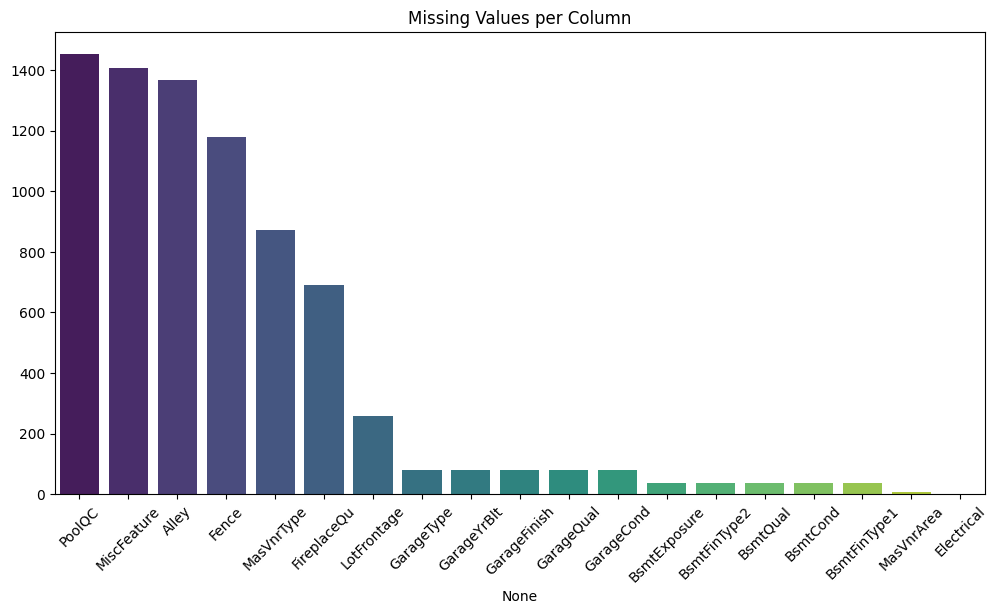

In [4]:
# Visualizing Missing Values
plt.figure(figsize=(12, 6))
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
sns.barplot(x=missing.index, y=missing.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Missing Values per Column")
plt.show()

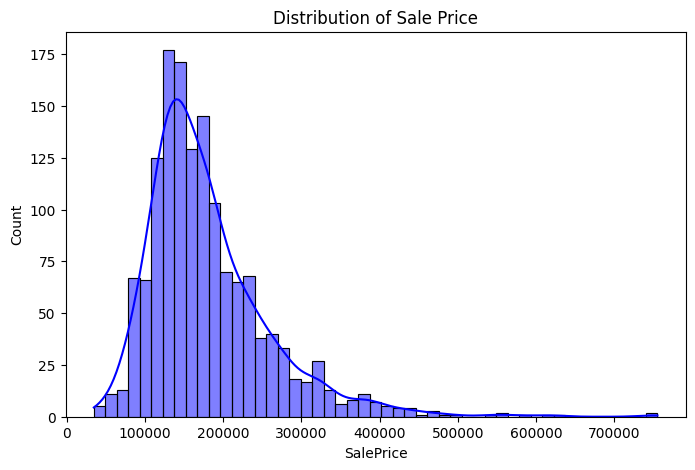

In [5]:
# Target Variable Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['SalePrice'], kde=True, color='blue')
plt.title("Distribution of Sale Price")
plt.show()

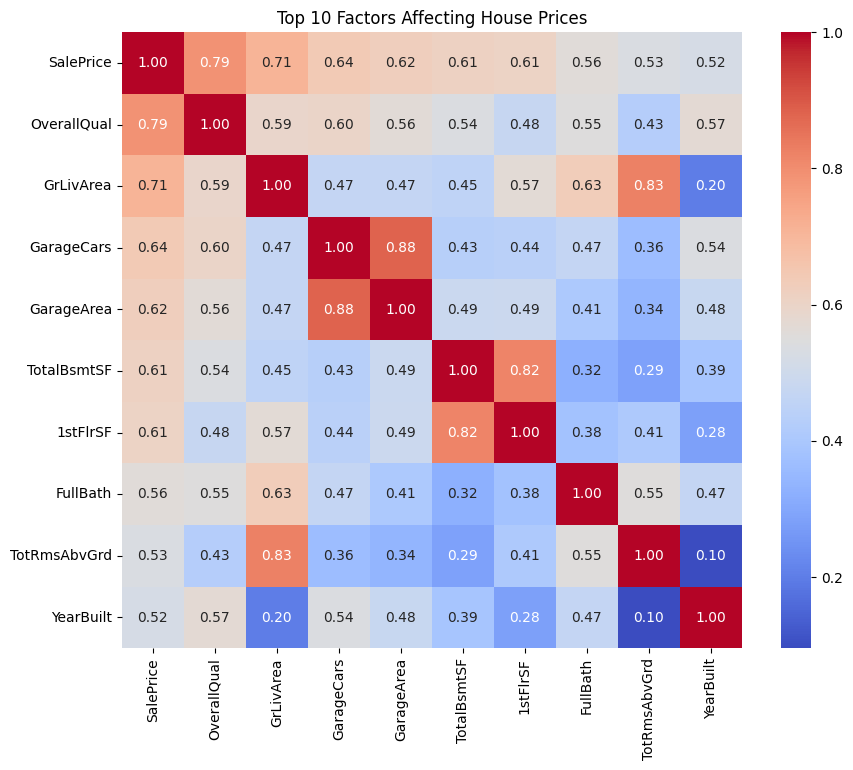

In [7]:
# Top 10 Correlations with SalePrice
plt.figure(figsize=(10, 8))

top_corr = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).head(10)

sns.heatmap(df[top_corr.index].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Top 10 Factors Affecting House Prices")
plt.show()

In [8]:
# 3. DATA TRANSFORMATION & CLEANING

# A) Handling Outliers
# GrLivArea is the most critical feature
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

# B) Log Transformation
df['SalePrice'] = np.log1p(df['SalePrice'])

# C) Basic Imputation & Encoding
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
X = df[features]
y = df['SalePrice']

# Fill any remaining NaNs with median
X = X.fillna(X.median())

In [9]:
# 4. DATA MODELLING

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Simple Baseline (Linear Regression)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Model 2: Stronger Model (Random Forest)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# Evaluation (RMSE)
def get_rmse(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    return np.sqrt(mse)

print("\n--- MODEL PERFORMANCE (RMSE) ---")
print(f"Linear Regression RMSE: {get_rmse(lr, X_test_scaled, y_test):.4f}")
print(f"Random Forest RMSE: {get_rmse(rf, X_test_scaled, y_test):.4f}")


--- MODEL PERFORMANCE (RMSE) ---
Linear Regression RMSE: 0.1647
Random Forest RMSE: 0.1662


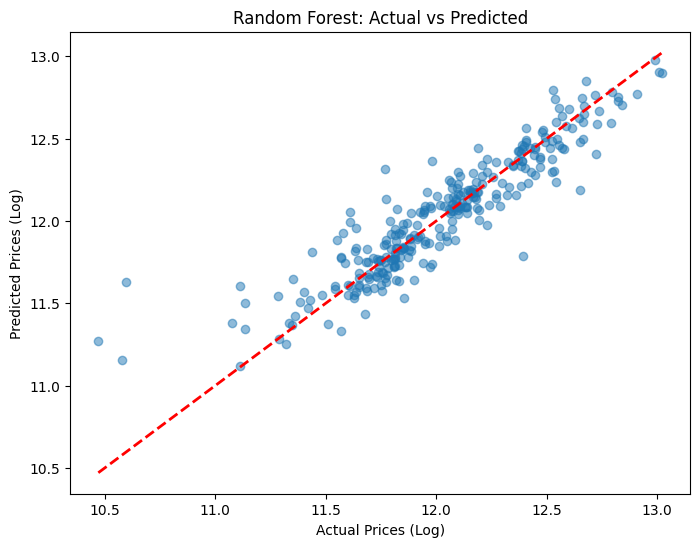

In [11]:
# 5. FINAL VISUALIZATION (Actual vs Predicted)
rf_preds = rf.predict(X_test_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices (Log)")
plt.ylabel("Predicted Prices (Log)")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

In [12]:
# 6. FEATURE ENGINEERING & FINAL MODELING
# I create a new feature to help the model: Total Square Footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Define my final feature list (Must match for train and test)
features_extended = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalSF', 'FullBath', 'YearBuilt']
X_ext = df[features_extended].fillna(df[features_extended].median())
y = df['SalePrice'] # This is already Log Transformed from previous steps

# Split, Scale and Train
X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_ext, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled_ext = scaler.fit_transform(X_train_ext)

final_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_rf_model.fit(X_train_scaled_ext, y_train_ext)

RandomForestRegressor(random_state=42)

In [14]:
# 7. SAVING
import joblib

joblib.dump(final_rf_model, 'house_price_model.joblib')
joblib.dump(scaler, 'house_price_scaler.joblib')
print("--- Model and Scaler are saved! ---")

# 8. GENERATING SUBMISSION.CSV
# 1. Load the real test data

test_df = pd.read_csv('test.csv')
test_ids = test_df['Id']

# 2. Apply the SAME transformations as training
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
X_submission = test_df[features_extended].fillna(test_df[features_extended].median())

# 3. Scale using the SAME scaler from training
X_submission_scaled = scaler.transform(X_submission)

# 4. Predict and Convert back from Log scale to Dollars
log_preds = final_rf_model.predict(X_submission_scaled)
final_preds = np.expm1(log_preds) # expm1 reverses log1p

# 5. Save to CSV
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': final_preds})
submission.to_csv('submission.csv', index=False)

print("--- submission.csv created successfully! ---")
submission.head()

--- Model and Scaler are saved! ---
--- submission.csv created successfully! ---


,Id,SalePrice
0,1461,119159.786856
1,1462,148671.018321
2,1463,169753.573447
3,1464,178630.663522
4,1465,214426.770332


In [15]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>